## Piping failure

This week, we explored the concept of soil conductivity, but the most interesting/practical is the application of piping failure.

In [16]:
import numpy as np
from seepage import solve
from seepage import flownet_upgraded as flownet
import matplotlib.pyplot as plt

In [ ]:
from typing import Any
from pydantic import BaseModel, Field

class Soil(BaseModel):
    k: Any
    gs: float
    e: float = Field(default=0.5)
    n: float = Field(default=0.3)
    nx:int
    ny:int
    Lx:int
    def __post_init__(self):
        self.gamma_w = 9.81  # kN/m^3
        self.gamma_s = self.gs * self.gamma_w
        self.gamma_d = self.gamma_s / (1 + self.e)
        self.gamma = self.gamma_d + self.n * self.gamma_w
        self.k = self.k * np.ones((self.ny, self.nx))
    def crit_grad(self) -> float:
        return (self.gamma_s - self.gamma_w) / self.gamma_w
class Scenario(BaseModel):
    bc: dict[str, float | None]
    soils: list[Soil]
    i_crit: float = Field(default=0.0)
    def __post_init__(self):
        self.i_crit = max(soil.crit_grad() for soil in self.soils)
    def calculate_head(self) -> float:
        for soil in self.soils:
            h, vx, vy = solve(soil.k, self.bc, soil.Lx)
        return h, vx, vy 

Converged in 2667 iterations.
i'm upgraded


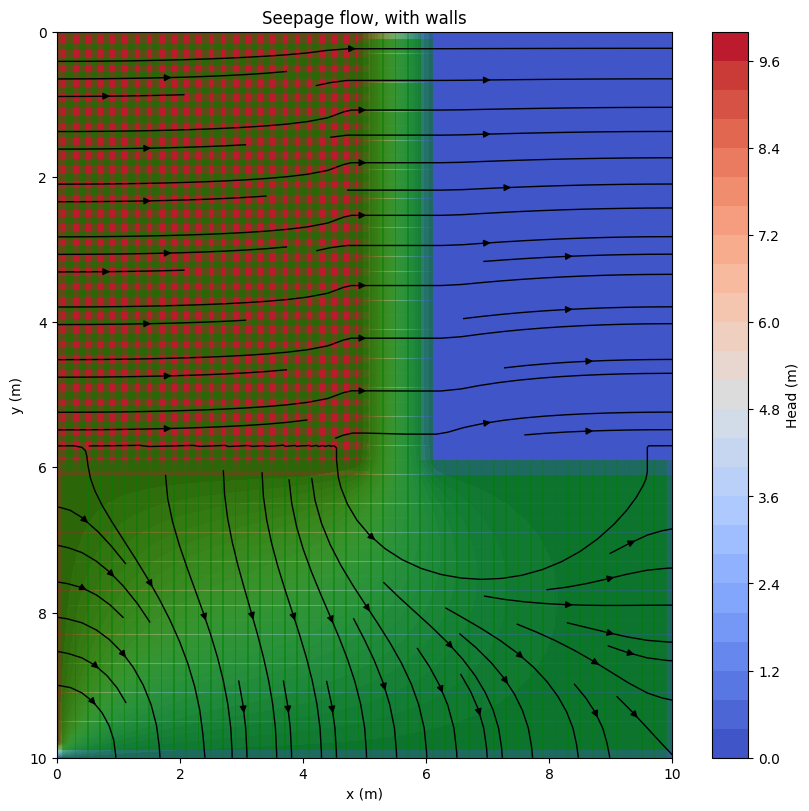

In [17]:
nx, ny = 50, 50 # number of simulation points in x and y direction
Lx = 10 # length of rectangular domain in x direction (m)
k = 1*np.ones((ny, nx)) # Permeability (m^2)
k[0:30, nx//2:nx//2+5] = 1e-20 # Heterogeneous permeability
k[0:30, nx//2+5:nx] = 1e20 # air, on the other side of the wall
k[30:50,:] = 1e-20 # Heterogeneous permeability

bc = {'left': 10, 'right': 0, 'top': None, 'bottom': 0}

h, vx, vy = solve(k, bc, Lx)
ix = -vx / k   # matrix of ∂h/∂x
iy = -vy / k   # matrix of ∂h/∂y
i_mag = np.sqrt(ix**2 + iy**2)  # matrix of |∇h| = hydraulic gradient magnitude

h_wall_only = h
flownet(h, k, bc, Lx, Nf=40, Nh=30, title = "Seepage flow, with walls")



In [18]:
ix = -vx / k   # matrix of ∂h/∂x
iy = -vy / k   # matrix of ∂h/∂y
i_mag = np.sqrt(ix**2 + iy**2)  # matrix of |∇h| = hydraulic gradient magnitude


Here, the hydraulic gradient is extracted from the head matrix

In [19]:
print(i_mag[30:,nx//2+7:].max())


2.2294798918528147
